<a href="https://colab.research.google.com/github/Aaron19890701/gdp-dashboard/blob/main/oxford_flowers_MobileNet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Do Better ImageNet Models Transfer Better?


## Library

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

## Parameter

In [2]:
NUM_GPUS = 1
BS_PER_GPU = 256 # Batchsize = 4x64
NUM_EPOCHS = 200
TASK=2 # Task 1 : Logistic Regression, Task2 : Transfer learning, Task3 : Random Initialization(Scratch Training)
MODEL = "mobilenet_v1" # mobilenet_v1, mobilenet_v2
NUM_CLASSES = 10
DATASET = "oxford_flowers102" # food101, cifar10, cifar100, sun397, oxford_flowers102, caltech101
learning_rate = 0.01

In [3]:
metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="top_K")]
if DATASET=="cifar10":
  NUM_CLASSES=10
elif DATASET=="cifar100":
  NUM_CLASSES=100
elif DATASET=="food101":
  NUM_CLASSES=101
elif DATASET=="sun397":
  NUM_CLASSES=397
elif DATASET=="oxford_flowers102" or DATASET=="caltech101":
  NUM_CLASSES=102
  metrics=["acc"]

## Dataset

In [4]:
def normalize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 127.5 - 1., label

In [5]:
(train_dataset, test_dataset), ds_info = tfds.load(
    DATASET,
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train = train_dataset.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BS_PER_GPU * NUM_GPUS)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = test_dataset.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BS_PER_GPU * NUM_GPUS)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.WABP40_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.WABP40_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.WABP40_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


## Model

In [6]:
if TASK==1:
    include_top=False
    weights="imagenet"
    trainable=False
elif TASK==2:
    include_top=False
    weights="imagenet"
    trainable=True
elif TASK==3:
    include_top=False
    weights=None
    trainable=True


if MODEL=="mobilenet_v1":
    base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3),
                                            include_top=include_top,
                                            weights=weights)
elif MODEL=="mobilenet_v2":
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                 include_top=include_top,
                                                 weights=weights)

# Freeze the pre-trained model weights
base_model.trainable = trainable

# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Layer classification head with feature detector
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    maxpool_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, decay=1e-6, nesterov=True),
              loss='sparse_categorical_crossentropy',
              metrics=metrics
              # metrics=["acc"]
)
print(model.summary())

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ ?                      │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

None


In [7]:

history = model.fit(ds_train,
          validation_data=ds_test,
          validation_freq=1,
          epochs=NUM_EPOCHS, shuffle=True)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 50s 9s/step - acc: 0.0112 - loss: 15.4774 - val_acc: 0.0296 - val_loss: 9.4465
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - acc: 0.1257 - loss: 13.4766 - val_acc: 0.0236 - val_loss: 7.0437
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - acc: 0.3305 - loss: 14.3008 - val_acc: 0.0247 - val_loss: 9.1431
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - acc: 0.5069 - loss: 12.0317 - val_acc: 0.0179 - val_loss: 9.3671
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - acc: 0.5523 - loss: 8.2360 - val_acc: 0.0434 - val_loss: 10.5820
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - acc: 0.6274 - loss: 3.8631 - val_acc: 0.0709 - val_loss: 13.4018
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - acc: 0.7047 - loss: 2.1400 - val_acc: 0.0642 - val_loss: 9.9487
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - acc: 0.7741 - loss: 1.2334 - val_acc: 0.0390 - val_loss: 8.3270
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - acc: 0.8633 - loss: 0.7

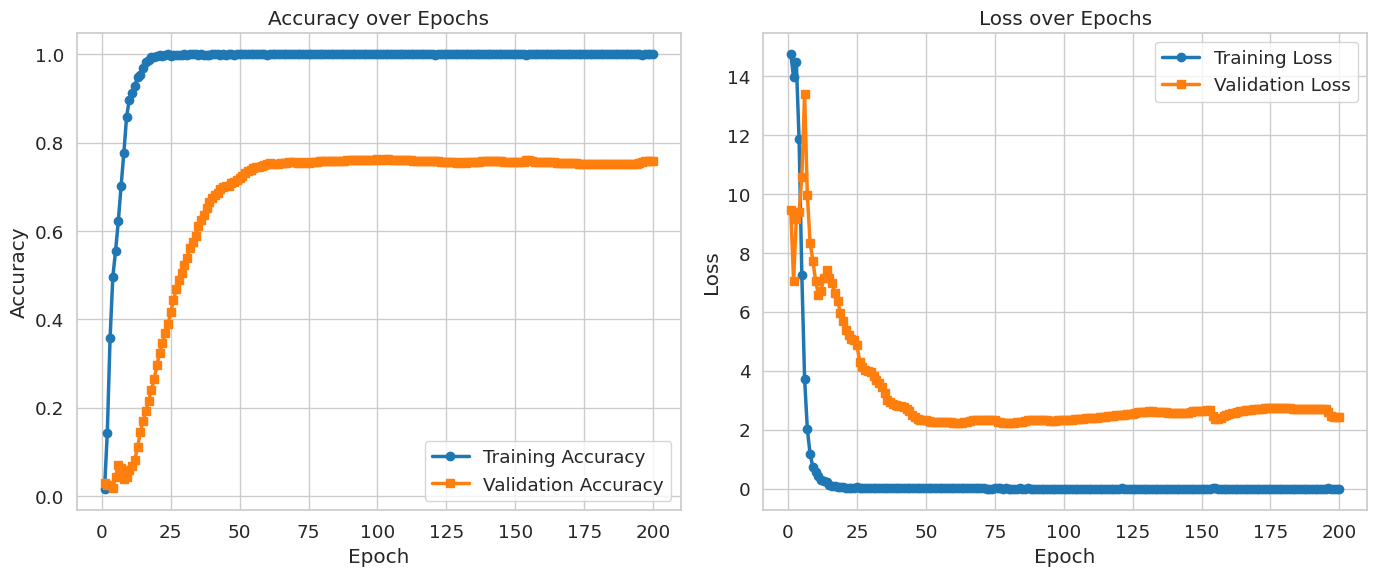

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

#  seaborn
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# get data from history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', color='tab:blue', linewidth=2.5, marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='tab:orange', linewidth=2.5, marker='s')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', color='tab:blue', linewidth=2.5, marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='tab:orange', linewidth=2.5, marker='s')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
